 ### ARJUN KC (8773456)

# Lab 10 - Fine-Tune VGG16 for Bird Classification

In this lab, we will work through a common practice of Deep Learning Engineers - that is - take an existing model, that does something similar to what the engineer is interested doing, and fine-tune it for the specific task at-hand. 

This lab is the last one, so it is a bit more elaborated than the others. So make sure to take time to work through it.

A good starting point is to use the code in the notebook we went over in class - for fine-tuning VGG16. 

The goal of this lab is to achieve the best classification performance over three classes (species) of birds. This should be done by exploring data augmentation and fine-tuning of a pre-trained model (VGG16). Finally, explore and describe the results. 

If you are interested, you are encouraged to explore various training configurations, and see which one works better.

1. Obtain the Data
    1. Download the [BIRDS 525 SPECIES](https://www.kaggle.com/datasets/gpiosenka/100-bird-species?select=train) dataset from Kaggle (CC0 license). You will need to create a free Kaggle account, and this will provide you free access to many such datasets, as well as code and even online notebooks. 
    2. Unpack the data. Notice that the data is organized into folders in a way similar to the Dogs vs Cats dataset that we worked with. This makes it easy to load with the same Keras function (`ImageDataGenerator.flow_from_directory`). 
    3. For this lab, we will work with the 3 classes with the highest number of images. Identify those classes, and use only these for the next steps. You can delete/discard the others.
2. Use data-augmentation to increase the number of training images. You are encouraged to try out various augmentation methods supported by Keras. The rule of thumb is that as long as an augmentation produces realistic images - it is probably a good idea to add it.(2 point)
3. Fine-Tune `VGG16` (pre-trained on `imagenet`), to classify the 3 classes (2 points)
4. Explore the model performance: accuracy, confusion metric, precision, recall, F1-score, precision-recall curve and its area under the curve (AUC). Explore specific examples in which the model failed to predict correctly. (2 points)

from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import shutil
import numpy as np
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from PIL import Image

In [49]:
from tensorflow import keras
from tensorflow.keras import layers
import pathlib
from tensorflow.keras.utils import image_dataset_from_directory
import matplotlib.pyplot as plt
import os
import numpy as np
import shutil
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score,roc_curve,auc
from sklearn.metrics import precision_recall_curve, auc
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize
from PIL import Image

 Setting the data folder path

In [2]:
data_folder = pathlib.Path("F:\Conestoga_college_course\AI_ML\CSCN8010_23S_SC1_Foundation_of_Machine_Learning\lab10\data")

Now Defining the path for train,test and validation

In [3]:
train_dir = data_folder / "train"
valid_dir = data_folder / "valid"
test_dir = data_folder / "test"

Now finding the top three classes with higher images

In [4]:
class_folders = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
class_image_counts = {}
for class_folder in class_folders:
    class_path = os.path.join(train_dir, class_folder)
    num_images = len(os.listdir(class_path))
    class_image_counts[class_folder] = num_images
sorted_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)
top_three_classes = sorted_classes[:3]
print(top_three_classes)
print("Top three classes with the highest number of images:")
for class_name, count in top_three_classes:
    print(f"{class_name}: {count} images")


[('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('D-ARNAUDS BARBET', 233)]
Top three classes with the highest number of images:
RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
D-ARNAUDS BARBET: 233 images


In [5]:
class_name_list = [class_info[0] for class_info in top_three_classes]
class_name_list

['RUFOUS TREPE', 'HOUSE FINCH', 'D-ARNAUDS BARBET']

Deleting the directories which are not the part of top three classes

In [6]:

for species in os.listdir(train_dir):
    if species not in class_name_list:
        delete_path_train = os.path.join(train_dir, species)
        if os.path.isdir(delete_path_train):
            shutil.rmtree(delete_path_train)

for species in os.listdir(test_dir):
    if species not in class_name_list:
        delete_path_test = os.path.join(test_dir, species)
        if os.path.isdir(delete_path_test):
            shutil.rmtree(delete_path_test)

for species in os.listdir(valid_dir):
    if species not in class_name_list:
        delete_path_valid = os.path.join(valid_dir, species)
        if os.path.isdir(delete_path_valid):
            shutil.rmtree(delete_path_valid)


In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Defining Data Agumentation and Preprocessing

Creating the ImageDatagenerator for train,validation and test sets

In [16]:
data_agu_pre = ImageDataGenerator(
   #rescale=1./255,                            
   horizontal_flip=True,      
   fill_mode='nearest'      
)

train_generator = data_agu_pre.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

valid_generator = data_agu_pre.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

test_generator = data_agu_pre.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 744 images belonging to 3 classes.
Found 15 images belonging to 3 classes.


Found 15 images belonging to 3 classes.


In [17]:
class_folders = [folder for folder in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, folder))]
class_image_counts = {}
for class_folder in class_folders:
    class_path = os.path.join(train_dir, class_folder)
    num_images = len(os.listdir(class_path))
    class_image_counts[class_folder] = num_images
sorted_classes = sorted(class_image_counts.items(), key=lambda x: x[1], reverse=True)
top_three_classes = sorted_classes[:3]
print(top_three_classes)
print("Top three classes with the highest number of images:")
for class_name, count in top_three_classes:
    print(f"{class_name}: {count} images")

[('RUFOUS TREPE', 263), ('HOUSE FINCH', 248), ('D-ARNAUDS BARBET', 233)]
Top three classes with the highest number of images:
RUFOUS TREPE: 263 images
HOUSE FINCH: 248 images
D-ARNAUDS BARBET: 233 images


In [18]:
num_batches = len(train_generator)
print("Number of batches in train_generator:", num_batches)

Number of batches in train_generator: 24


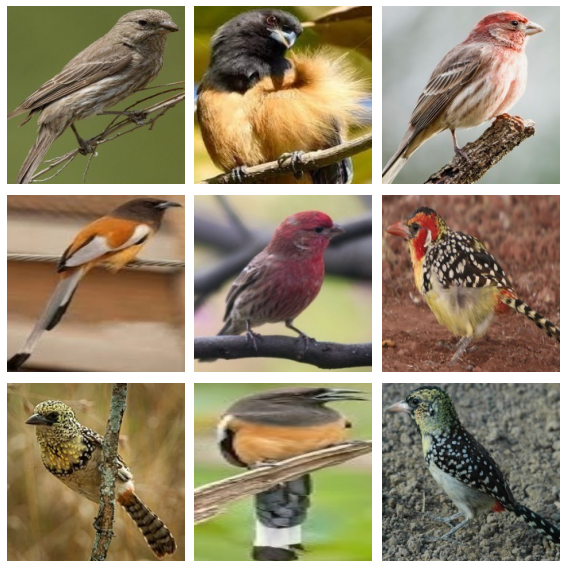

In [23]:
plt.figure(figsize=(8, 8))
for i in range(9):
    image, label = train_generator.next()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

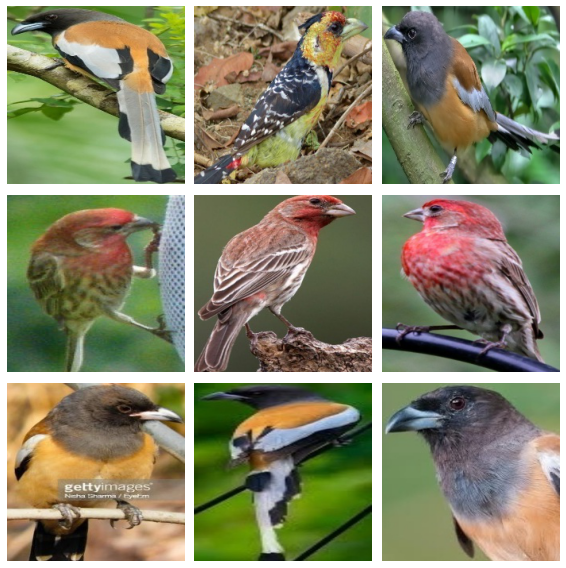

In [25]:
plt.figure(figsize=(8, 8))
for i in range(9):
    image, label = train_generator.next()
    plt.subplot(3, 3, i + 1)
    plt.imshow(image[0].astype("uint8"))
    plt.axis("off")
plt.tight_layout()
plt.show()

Loading the model VVG16 with pre-train weights

In [27]:
bas_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
bas_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Now Adding a custom top layer for bird species classification

In [34]:
x = bas_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(3, activation='softmax')(x)
model = Model(inputs=bas_model.input, outputs=predictions)
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Now freezing the base VVG16layers 

In [37]:
for layer in bas_model.layers:
    layer.trainable = False

Now Compiling the model

In [41]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

                                                                 
Total params: 14978883 (57.14 MB)
Trainable params: 264195 (1.01 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


Now train the model using fit method

In [43]:
history = model.fit(train_generator,epochs=10,validation_data=valid_generator)

Epoch 1/10
24/24 [==============================] - 155s 6s/step - loss: 2.6454 - accuracy: 0.7688 - val_loss: 4.1372e-05 - val_accuracy: 1.0000
Epoch 2/10
24/24 [==============================] - 145s 6s/step - loss: 0.0880 - accuracy: 0.9839 - val_loss: 7.4203e-04 - val_accuracy: 1.0000
Epoch 3/10
24/24 [==============================] - 145s 6s/step - loss: 0.0344 - accuracy: 0.9906 - val_loss: 4.4662e-06 - val_accuracy: 1.0000
Epoch 4/10
24/24 [==============================] - 144s 6s/step - loss: 0.0062 - accuracy: 0.9973 - val_loss: 1.1336e-04 - val_accuracy: 1.0000
Epoch 5/10
24/24 [==============================] - 147s 6s/step - loss: 0.0064 - accuracy: 0.9973 - val_loss: 8.7812e-06 - val_accuracy: 1.0000
Epoch 6/10
24/24 [==============================] - 145s 6s/step - loss: 0.0023 - accuracy: 0.9987 - val_loss: 1.7601e-05 - val_accuracy: 1.0000
Epoch 7/10
24/24 [==============================] - 145s 6s/step - loss: 5.7022e-04 - accuracy: 1.0000 - val_loss: 1.8125e-05 - va

Evaluating the model

In [53]:
y_prd = model.predict(valid_generator)
y_pred_tre = valid_generator.classes
y_pred_cls = np.argmax(y_prd, axis=1)

1/1 [==============================] - 2s 2s/step


Calculating the metrics

In [85]:
accuracy = accuracy_score(y_pred_cls, y_pred_cls)
confusion_mat = confusion_matrix(y_pred_tre, y_pred_cls)
confusion_mat
report = classification_report(y_pred_tre, y_pred_cls,target_names=valid_generator.class_indices.keys())

Ploting the precision recall curve and calculating AUC

In [86]:
fpr, tpr, thresholds = roc_curve(y_pred_tre, y_prd[:, 0], pos_label=1)
roc_auc = auc(fpr, tpr)

Printing the metrics

In [87]:
print("Accuracy: ", accuracy)
print("Confusion Matrix:\n", confusion_mat)
print("Classification Report:\n", report)
print("ROC AUC: ", roc_auc)

Accuracy:  1.0
Confusion Matrix:
 [[0 4 1]
 [2 0 3]
 [3 1 1]]
Classification Report:
                   precision    recall  f1-score   support

D-ARNAUDS BARBET       0.00      0.00      0.00         5
     HOUSE FINCH       0.00      0.00      0.00         5
    RUFOUS TREPE       0.20      0.20      0.20         5

        accuracy                           0.07        15
       macro avg       0.07      0.07      0.07        15
    weighted avg       0.07      0.07      0.07        15

ROC AUC:  0.52


Ploting ROC curve

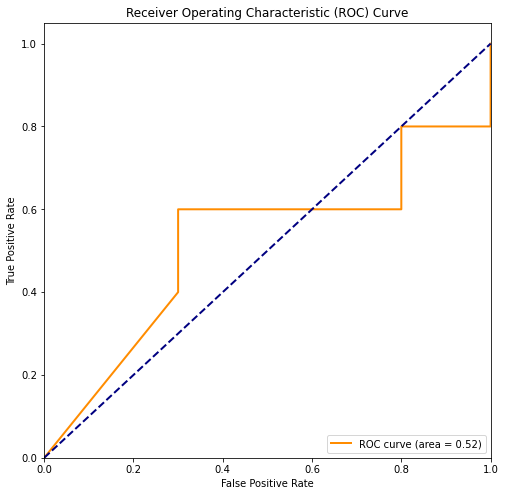

In [88]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Ploting the misclassified image where model predict to fail

1/1 [==============================] - 3s 3s/step


C:\Users\Dell\AppData\Local\Temp/ipykernel_18472/912111860.py:4: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  misclassified_indices.extend(np.where(predicted_labels != true_labels)[0] + i * valid_generator.batch_size)


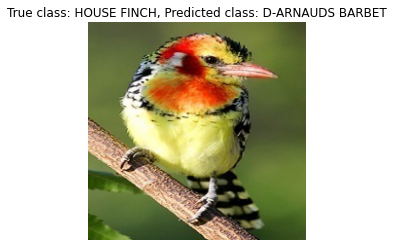

In [122]:
misclassified_indices = []
for i, (img_batch, true_labels) in enumerate(valid_generator):
    predicted_labels = np.argmax(model.predict(img_batch), axis=1)
    misclassified_indices.extend(np.where(predicted_labels != true_labels)[0] + i * valid_generator.batch_size)
    if len(misclassified_indices) >= 1:
        break

# Invert the class_indices dictionary to get class_names
class_names = {v: k for k, v in valid_generator.class_indices.items()}

# Plot the first 5 misclassified examples
for idx in misclassified_indices[:5]:
    img = img_batch[idx % valid_generator.batch_size]
    true_class_name = class_names[int(true_labels.flatten()[idx % valid_generator.batch_size])]
    predicted_class_name = class_names[int(predicted_labels.flatten()[idx % valid_generator.batch_size])]

    plt.imshow(img.astype('uint8'))
    plt.title(f'True class: {true_class_name}, Predicted class: {predicted_class_name}')
    plt.axis('off')
    plt.show()